Target - Create a model with higher training accuracy, lower number of parametrs reduction in overfitting and better train accuracy

Results
6.4k parameters
Train Accuracy - 98.73
Test Accuracy - 98.86

Analysis

Reduced the number of parameters
Reduced gap between train and train accuracy (reduce overfitting)
Introduced Bn for better accuracy
Introduced Dropout to reduce overfitting
Introduced Image Auggmentation technique to improve accuracy
Need to improve test/traij accuracy further

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 4

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
train.train_data.shape


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

# The model
Let's start with the model we first saw

In [6]:
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.ReLU()

        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # OUTPUT BLOCK
       # self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),

        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
       # x = self.pool2(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.convblock6(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
         MaxPool2d-9           [-1, 20, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             200
           Conv2d-11           [-1, 15, 10, 10]           1,350
             ReLU-12           [-1, 15, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [9]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.2487105131149292 Batch_id=468 Accuracy=78.72: 100%|██████████| 469/469 [00:25<00:00, 18.52it/s]



Test set: Average loss: 0.2246, Accuracy: 9408/10000 (94.08%)

EPOCH: 1


Loss=0.15903006494045258 Batch_id=468 Accuracy=95.87: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]



Test set: Average loss: 0.1060, Accuracy: 9718/10000 (97.18%)

EPOCH: 2


Loss=0.07667284458875656 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]



Test set: Average loss: 0.0776, Accuracy: 9791/10000 (97.91%)

EPOCH: 3


Loss=0.11938372999429703 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]



Test set: Average loss: 0.0582, Accuracy: 9852/10000 (98.52%)

EPOCH: 4


Loss=0.10842454433441162 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]



Test set: Average loss: 0.0825, Accuracy: 9760/10000 (97.60%)

EPOCH: 5


Loss=0.03993476927280426 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]



Test set: Average loss: 0.0702, Accuracy: 9796/10000 (97.96%)

EPOCH: 6


Loss=0.10351913422346115 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]



Test set: Average loss: 0.0573, Accuracy: 9826/10000 (98.26%)

EPOCH: 7


Loss=0.09322159737348557 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]



Test set: Average loss: 0.0491, Accuracy: 9870/10000 (98.70%)

EPOCH: 8


Loss=0.061401765793561935 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]



Test set: Average loss: 0.0440, Accuracy: 9872/10000 (98.72%)

EPOCH: 9


Loss=0.0984964445233345 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]



Test set: Average loss: 0.0479, Accuracy: 9845/10000 (98.45%)

EPOCH: 10


Loss=0.05912112817168236 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]



Test set: Average loss: 0.0377, Accuracy: 9886/10000 (98.86%)

EPOCH: 11


Loss=0.09019012004137039 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]



Test set: Average loss: 0.0390, Accuracy: 9885/10000 (98.85%)

EPOCH: 12


Loss=0.02687773108482361 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]



Test set: Average loss: 0.0370, Accuracy: 9888/10000 (98.88%)

EPOCH: 13


Loss=0.01565544307231903 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.0374, Accuracy: 9884/10000 (98.84%)

EPOCH: 14


Loss=0.03875325992703438 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0369, Accuracy: 9886/10000 (98.86%)



Text(0.5, 1.0, 'Test Accuracy')

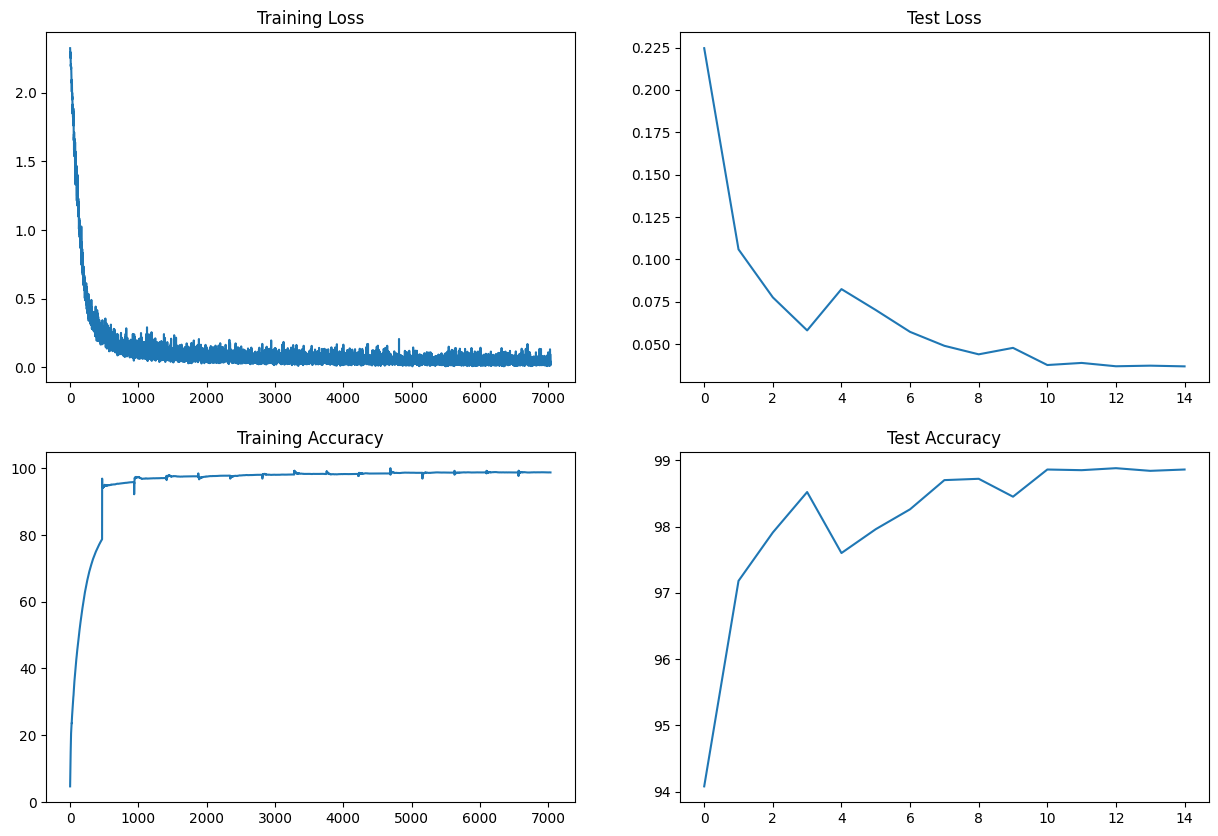

In [10]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")